In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import (
    Wav2Vec2Processor, Wav2Vec2Model,
    AutoFeatureExtractor, HubertModel,
    WhisperFeatureExtractor, WhisperModel
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score
)
from sklearn.model_selection import StratifiedShuffleSplit
import torchaudio
import json
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# DEVICE & CONSTANTS
# ============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE = {DEVICE}")

DATA_DIR = "/kaggle/input/vietnamese-speech-emotion-recognition-dataset"
OUTPUT_DIR = "models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

EMOTION_CLASSES = ['happy', 'neutral', 'sad', 'angry']
EMOTION_MAP = {label: idx for idx, label in enumerate(EMOTION_CLASSES)}

# Config for training
CONFIG = {
    'min_duration': 0.5,
    'max_duration': 15.0,
    'sample_rate': 16000,
    'batch_size': 16,
    'epochs': 5,
    'warmup_steps': 500,
    'learning_rate': 1e-5,
    'weight_decay': 0.01,
    'patience': 5,
    'random_seed': 42,
}

torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

2025-12-28 02:38:26.467003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766889506.854092      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766889506.966372      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766889507.971256      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766889507.971298      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766889507.971301      55 computation_placer.cc:177] computation placer alr

DEVICE = cuda


In [2]:
print("\n" + "="*60)
print("STEP 1: LOAD DATA FROM FOLDER STRUCTURE")
print("="*60)

def load_audio_dataset(data_dir):
    datasets = {}
    
    for split in ['train/phase1', 'train/phase2', 'val', 'test']:
        split_path = os.path.join(data_dir, split)
        data = []
        
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} not found!")
            continue
        
        for emotion in EMOTION_CLASSES:
            emotion_dir = os.path.join(split_path, emotion)
            
            if not os.path.exists(emotion_dir):
                continue
            
            for filename in os.listdir(emotion_dir):
                if filename.endswith('.wav'):
                    filepath = os.path.join(emotion_dir, filename)
                    try:
                        # Load audio & calculate duration
                        waveform, sr = torchaudio.load(filepath)
                        
                        # Resample if needed
                        if sr != CONFIG['sample_rate']:
                            waveform = torchaudio.functional.resample(
                                waveform, sr, CONFIG['sample_rate']
                            )
                            sr = CONFIG['sample_rate']
                        
                        duration = waveform.shape[1] / sr
                        
                        # Filter by duration
                        if CONFIG['min_duration'] <= duration <= CONFIG['max_duration']:
                            data.append({
                                'audio_path': filepath,
                                'emotion': emotion,
                                'emotion_id': EMOTION_MAP[emotion],
                                'duration': duration,
                                'split': split.split('/') if '/' in split else split
                            })
                    except Exception as e:
                        print(f"Error loading {filepath}: {e}")
        
        if data:
            datasets[split] = pd.DataFrame(data)
            print(f"{split}: {len(data)} files")
            print(f"  Emotion distribution: {datasets[split]['emotion'].value_counts().to_dict()}")
    
    return datasets

datasets = load_audio_dataset(DATA_DIR)

# Check if we have data
df_phase1 = datasets.get('train/phase1', pd.DataFrame())
df_phase2 = datasets.get('train/phase2', pd.DataFrame())
df_val = datasets.get('val', pd.DataFrame())
df_test = datasets.get('test', pd.DataFrame())

print(f"\nTotal samples:")
print(f"  Phase1: {len(df_phase1)}")
print(f"  Phase2: {len(df_phase2)}")
print(f"  Val: {len(df_val)}")
print(f"  Test: {len(df_test)}")


STEP 1: LOAD DATA FROM FOLDER STRUCTURE
train/phase1: 3693 files
  Emotion distribution: {'happy': 1060, 'angry': 1030, 'neutral': 854, 'sad': 749}
train/phase2: 3772 files
  Emotion distribution: {'happy': 1063, 'angry': 1049, 'neutral': 877, 'sad': 783}
val: 792 files
  Emotion distribution: {'happy': 226, 'angry': 220, 'neutral': 184, 'sad': 162}
test: 944 files
  Emotion distribution: {'happy': 266, 'angry': 262, 'neutral': 220, 'sad': 196}

Total samples:
  Phase1: 3693
  Phase2: 3772
  Val: 792
  Test: 944


In [3]:
print("\n" + "="*60)
print("STEP 2: DATASET CLASS")
print("="*60)

class AudioEmotionDataset(Dataset):
    """Load audio files and compute features"""
    def __init__(self, df, processor=None, feature_extractor=None, mode='wav2vec'):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.feature_extractor = feature_extractor
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path']
        label = row['emotion_id']
        
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Ensure mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(0, keepdim=True)
        
        waveform = waveform.squeeze(0).numpy().astype(np.float32)
        
        # Resample if needed
        if sr != CONFIG['sample_rate']:
            waveform = torchaudio.functional.resample(
                torch.from_numpy(waveform), sr, CONFIG['sample_rate']
            ).numpy()
        
        return {
            'waveform': waveform,
            'labels': label
        }


STEP 2: DATASET CLASS


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

EMOTION_CLASSES = ['happy', 'neutral', 'sad', 'angry']
NUM_LABELS = len(EMOTION_CLASSES)

CONFIG = {
    "sample_rate": 16000,
    "batch_size": 16,
    "lr": 1e-5,
    "weight_decay": 1e-2,
    "seed": 42
}

torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])


DEVICE = cuda


In [5]:
whisper_extractor = WhisperFeatureExtractor.from_pretrained(
    "openai/whisper-small"
)

def collate_whisper(batch):
    waveforms = [b["waveform"] for b in batch]
    labels = [b["labels"] for b in batch]

    features = whisper_extractor(
        waveforms,
        sampling_rate=CONFIG["sample_rate"],
        return_tensors="pt"
    )

    input_features = features["input_features"]

    max_len = 3000
    padded = []
    for feat in input_features:
        if feat.shape[-1] < max_len:
            feat = F.pad(feat, (0, max_len - feat.shape[-1]))
        else:
            feat = feat[:, :max_len]
        padded.append(feat)

    return {
        "input_features": torch.stack(padded),
        "labels": torch.tensor(labels, dtype=torch.long)
    }


preprocessor_config.json: 0.00B [00:00, ?B/s]

In [6]:
class WhisperAttentionClassifier(nn.Module):
    def __init__(self, num_labels=4):
        super().__init__()
        self.encoder = WhisperModel.from_pretrained("openai/whisper-tiny").encoder
        hidden_size = 384  # Whisper-tiny
        
        # Attention layer
        self.attn_query = nn.Linear(hidden_size, 1, bias=False)
        
        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_labels)
        )
    
    def forward(self, input_features, labels=None):
        # Encode
        out = self.encoder(input_features=input_features)
        hidden = out.last_hidden_state  # [B, T, 384]
        
        # Attention
        attn_scores = self.attn_query(hidden)  # [B, T, 1]
        attn_weights = F.softmax(attn_scores, dim=1)  # [B, T, 1]
        
        # Context vector
        context = (attn_weights * hidden).sum(dim=1)  # [B, 384]
        
        # Classify
        logits = self.fc(context)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return {'logits': logits, 'loss': loss}


In [7]:
def freeze_whisper_except_last_n(model, n=3):
    # 1. Freeze toàn bộ encoder
    for p in model.encoder.parameters():
        p.requires_grad = False

    # 2. Unfreeze last n Whisper encoder layers
    for layer in model.encoder.layers[-n:]:
        for p in layer.parameters():
            p.requires_grad = True

    # 3. Unfreeze attention pooling
    for p in model.attn_query.parameters():
        p.requires_grad = True

    # 4. Unfreeze classification head
    for p in model.fc.parameters():
        p.requires_grad = True


In [8]:
class SimpleTrainer:
    def __init__(self, model, loader, optimizer):
        self.model = model
        self.loader = loader
        self.optimizer = optimizer

    def train(self, epochs, phase_name=""):
        """
        Train model and return per-epoch average loss for learning curve
        """
        self.model.train()
        epoch_losses = []

        for ep in range(epochs):
            total_loss = 0

            for batch in tqdm(self.loader, desc=f"{phase_name} Epoch {ep+1}/{epochs}"):
                # Move batch to device
                batch = {k: v.to(DEVICE) for k, v in batch.items()}

                # Forward + Backward
                self.optimizer.zero_grad()
                out = self.model(**batch)
                loss = out["loss"]
                loss.backward()

                # Gradient clipping & step
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(self.loader)
            epoch_losses.append(avg_loss)
            print(f"{phase_name} Epoch {ep+1}: loss = {avg_loss:.4f}")

        return epoch_losses


In [9]:
def plot_learning_curve(epoch_losses, title="Learning Curve"):
    plt.figure(figsize=(8,5))
    plt.plot(epoch_losses, marker='o', color='darkblue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]


===== PHASE 1: TRAIN ON DF_PHASE1 (6 EPOCHS) =====


PHASE1 Epoch 1/6: 100%|██████████| 231/231 [03:39<00:00,  1.05it/s]


PHASE1 Epoch 1: loss = 1.2116


PHASE1 Epoch 2/6: 100%|██████████| 231/231 [03:40<00:00,  1.05it/s]


PHASE1 Epoch 2: loss = 0.9279


PHASE1 Epoch 4/6: 100%|██████████| 231/231 [03:39<00:00,  1.05it/s]


PHASE1 Epoch 4: loss = 0.7034


PHASE1 Epoch 5/6: 100%|██████████| 231/231 [03:40<00:00,  1.05it/s]


PHASE1 Epoch 5: loss = 0.6132


PHASE1 Epoch 6/6: 100%|██████████| 231/231 [03:39<00:00,  1.05it/s]


PHASE1 Epoch 6: loss = 0.5304


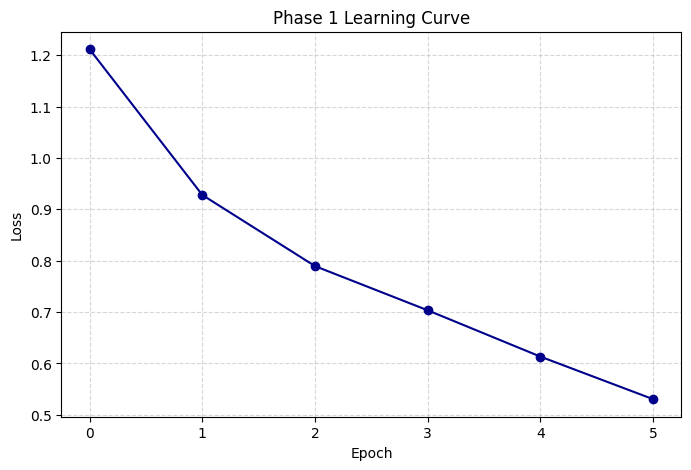

In [10]:
dataset_p1 = AudioEmotionDataset(df_phase1, mode="whisper")
loader_p1 = DataLoader(
    dataset_p1,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_whisper
)

model = WhisperAttentionClassifier(NUM_LABELS).to(DEVICE)
freeze_whisper_except_last_n(model, n=3)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"]
)

trainer = SimpleTrainer(model, loader_p1, optimizer)

print("\n===== PHASE 1: TRAIN ON DF_PHASE1 (6 EPOCHS) =====")
epoch_losses = trainer.train(epochs=6, phase_name="PHASE1")
plot_learning_curve(epoch_losses, title="Phase 1 Learning Curve")



===== PHASE 2: TRAIN ON MERGED DATA (9 EPOCHS) =====


PHASE2 Epoch 1/9: 100%|██████████| 576/576 [09:11<00:00,  1.04it/s]


PHASE2 Epoch 1: loss = 0.5152


PHASE2 Epoch 2/9: 100%|██████████| 576/576 [09:10<00:00,  1.05it/s]


PHASE2 Epoch 2: loss = 0.3819


PHASE2 Epoch 3/9: 100%|██████████| 576/576 [09:11<00:00,  1.04it/s]


PHASE2 Epoch 3: loss = 0.2718


PHASE2 Epoch 4/9: 100%|██████████| 576/576 [09:12<00:00,  1.04it/s]


PHASE2 Epoch 4: loss = 0.1919


PHASE2 Epoch 5/9: 100%|██████████| 576/576 [09:14<00:00,  1.04it/s]


PHASE2 Epoch 5: loss = 0.1367


PHASE2 Epoch 7/9: 100%|██████████| 576/576 [09:13<00:00,  1.04it/s]


PHASE2 Epoch 7: loss = 0.0680


PHASE2 Epoch 8/9: 100%|██████████| 576/576 [09:15<00:00,  1.04it/s]


PHASE2 Epoch 8: loss = 0.0476


PHASE2 Epoch 9/9: 100%|██████████| 576/576 [09:13<00:00,  1.04it/s]

PHASE2 Epoch 9: loss = 0.0363


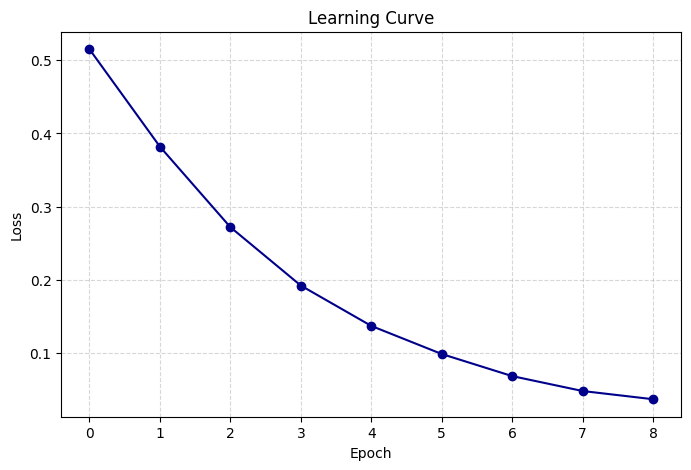

In [11]:
df_all = pd.concat(
    [df_phase1, df_phase2, df_val, df_test],
    ignore_index=True
)

dataset_p2 = AudioEmotionDataset(df_all, mode="whisper")
loader_p2 = DataLoader(
    dataset_p2,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=collate_whisper
)

trainer.loader = loader_p2

print("\n===== PHASE 2: TRAIN ON MERGED DATA (9 EPOCHS) =====")
epoch_losses = trainer.train(epochs=9, phase_name="PHASE2")
plot_learning_curve(epoch_losses, title="Learning Curve")


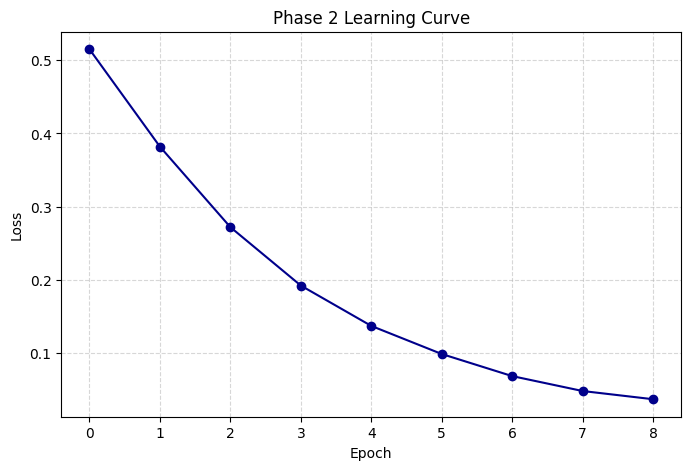

In [15]:
plot_learning_curve(epoch_losses, title="Phase 2 Learning Curve")

In [12]:
FINAL_DIR = "final"
os.makedirs(FINAL_DIR, exist_ok=True)

final_path = os.path.join(FINAL_DIR, "whisper_emotion_final.pt")
torch.save(model.state_dict(), final_path)

print(f"\n✅ FINAL MODEL SAVED: {final_path}")



✅ FINAL MODEL SAVED: final/whisper_emotion_final.pt


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, loader, device=DEVICE, labels_map=None):
    """
    Evaluate model on a full dataset and compute metrics + confusion matrix.
    Returns: dict(metrics), confusion_matrix
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            logits = out["logits"]
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    metrics = {"precision": precision, "recall": recall, "f1_score": f1}

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels_map, yticklabels=labels_map)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    return metrics, cm


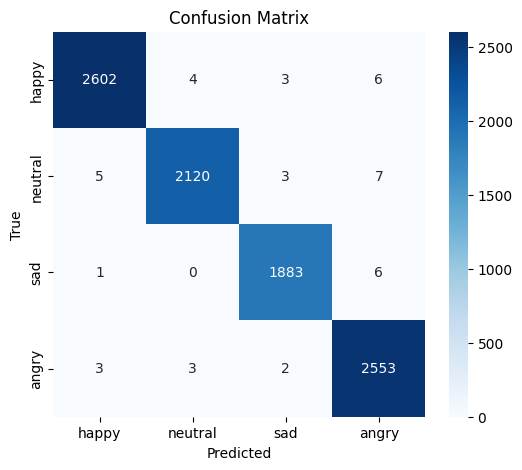


===== Metrics trên toàn bộ dataset merged =====
{'precision': 0.9954110528693967, 'recall': 0.9952938590217464, 'f1_score': 0.995350274320512}


In [14]:
# 1. Chuẩn bị loader cho toàn bộ dataset merged
dataset_full = AudioEmotionDataset(df_all, mode="whisper")
loader_full = DataLoader(
    dataset_full,
    batch_size=CONFIG["batch_size"],
    shuffle=False,  # shuffle=False để đánh giá ổn định
    collate_fn=collate_whisper
)

# 2. Định nghĩa nhãn (theo 4 label của bạn)
labels_map = EMOTION_CLASSES

# 3. Gọi hàm evaluate_model
metrics, cm = evaluate_model(trainer.model, loader_full, labels_map=labels_map)

print("\n===== Metrics trên toàn bộ dataset merged =====")
print(metrics)
